Absolute mean x error:  35.93644131333334
Absolute mean y error:  53.46433285183333


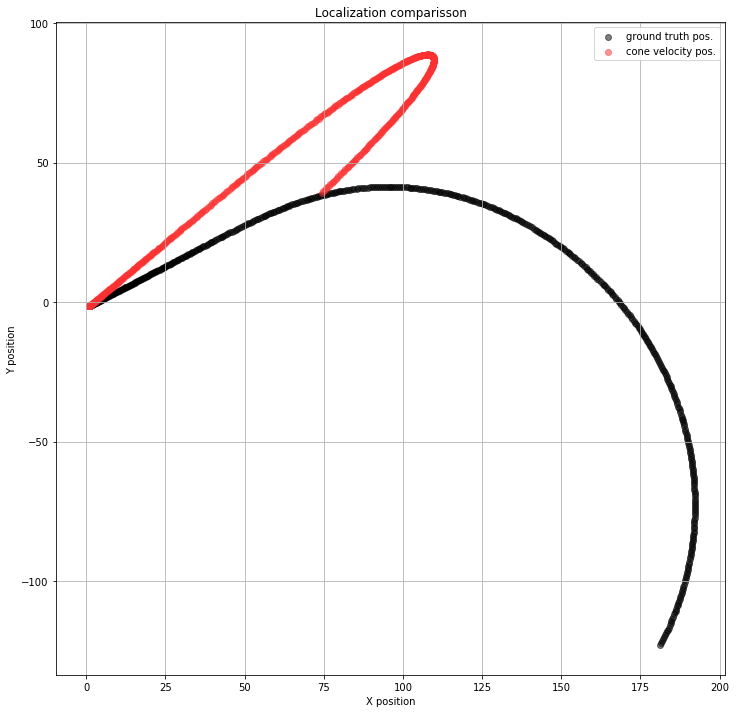

In [17]:
import matplotlib.pyplot as plt
import numpy             as np
import csv
%matplotlib inline
import mpld3
mpld3.enable_notebook()

from ipywidgets import interact
import ipywidgets as widgets

def read_debug_info(path):
    '''
    '''

    x_car_list = np.array([])
    y_car_list = np.array([])
    estim_x_car_list = np.array([])
    estim_y_car_list = np.array([])

    with open(path, 'r') as csvfile:
        reader = csv.reader(csvfile, skipinitialspace=False, delimiter=',')
        for row in reader:
            x_car = row[0]
            y_car = row[1]
            estimated_x_car = row[2]
            estimated_y_car = row[3]
            x_car_list = np.append(x_car_list, x_car)
            y_car_list = np.append(y_car_list, y_car)
            estim_x_car_list = np.append(estim_x_car_list, estimated_x_car)
            estim_y_car_list = np.append(estim_y_car_list, estimated_y_car)

    return x_car_list, y_car_list, estim_x_car_list, estim_y_car_list


# path = '../example-data/wemding-map-ground-truth-cones-d-a-x-y-c-t.csv'
# yellow_cone_ground_truth_x,   yellow_cone_ground_truth_y, blue_cone_ground_truth_x, blue_cone_ground_truth_y, red_cone_ground_truth_x,  red_cone_ground_truth_y = read_ground_truth(path)


x_car_list, y_car_list, estim_x_car_list, estim_y_car_list = read_debug_info('logging.log')

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title("Localization comparisson")


start = 0
cut = 600
#for i in range(start, cut, 10):
#    ax.annotate("g_"+str(i), (x_car_list[i], y_car_list[i]))
#    ax.annotate("e_"+str(i), (estim_x_car_list[i], estim_y_car_list[i]))

a = plt.scatter(x_car_list[start:cut], y_car_list[start:cut], color='black', alpha=0.5, label='ground truth pos.')
b = plt.scatter(estim_x_car_list[start:cut], estim_y_car_list[start:cut], color='#ff3030', alpha=0.5, label='cone velocity pos.')

l = [abs(float(x) - float(ex)) for (x, ex) in zip(x_car_list[start:cut], estim_x_car_list[start:cut])]
print("Absolute mean x error: ",  sum(l) / len(l) )

l = [abs(float(y) - float(ey)) for (y, ey) in zip(y_car_list[start:cut], estim_y_car_list[start:cut])]
print("Absolute mean y error: ", sum(l) / len(l) )

plt.legend(handles=[a, b])
plt.grid()
plt.show()

# cone velocity + sensor single step future prediction
# different Hz
# Absolute mean x error:  0.09889422554890276
# Absolute mean y error:  0.04933207365269439
# 30Hz
# Absolute mean x error:  0.6447419924999991
# Absolute mean y error:  0.5681491343149998
# 30 Hz + 4.6k observations
# Absolute mean x error:  1.6225510939173917
# Absolute mean y error:  1.609299571636958


# sensor 
# Absolute mean x error:  0.5965893193612777
# Absolute mean y error:  0.4253640241516964
# 30 Hz
# Absolute mean x error:  0.22161626599999942
# Absolute mean y error:  0.2035308127500002
# 30 Hz + 4.6k observations
# Absolute mean x error:  0.2217981149999995
# Absolute mean y error:  0.2114066748913047


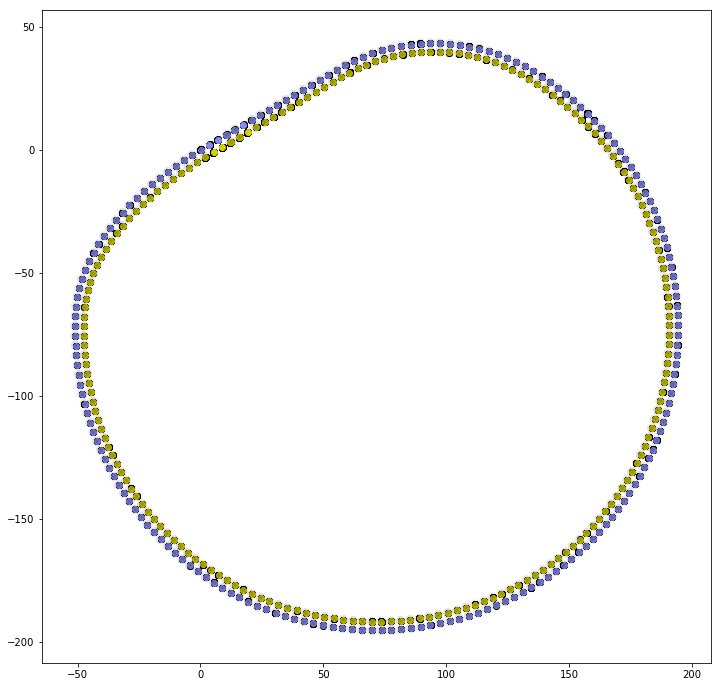

In [18]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import matplotlib.pyplot as plt
import numpy             as np
import csv
from matplotlib.patches import Ellipse

from cppdebuginfo import yellow_cone_data, blue_cone_data, red_cone_data 
from cppdebuginfo import yellow_obs_cone_data, blue_obs_cone_data, red_obs_cone_data 

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, facecolor='black', **kwargs))

def plot_cluster_intrinsics(data, ax=None, color="black"):
    """Use the data with the following format to plot the map
    
    yellow_cone_data = np.array([
        np.array([[3.76783, -1.95591], [[3.15856e-07, 1.10833e-05], [1.10833e-05, 0.000417146]], [0.0372671]]),
        ...        mean_x     mean_y      cov_xx        cov_xy        cov_xy        cov_yy          weight (of cluster)
        ...
        ])

    """
    positions = data[:, 0]
    covariances = data[:, 1]
    weights = data[:, 2]
    pos_x = [e[0] for e in positions]
    pos_y = [e[1] for e in positions]

    ax.scatter(pos_x, pos_y, color=color)
    for pos, covar, w in zip(positions, covariances, weights):
        draw_ellipse(np.array(pos), np.array(covar), ax=ax, alpha=0.1)


def read_ground_truth(path):
    """Reads data from the csv file without a header, formatted like this:

        --, --, x, y, color

    """
    yellow_cone_ground_truth_x = np.array([])
    yellow_cone_ground_truth_y = np.array([])
    blue_cone_ground_truth_x   = np.array([])
    blue_cone_ground_truth_y   = np.array([])
    red_cone_ground_truth_x    = np.array([])
    red_cone_ground_truth_y    = np.array([])

    with open(path, 'rb') as csvfile:
        reader = csv.reader(csvfile, skipinitialspace=False, delimiter=',')
        for row in reader:
            x = row[2]
            y = row[3]
            color = row[4]
            if color == ' 0':
                yellow_cone_ground_truth_x = np.append(yellow_cone_ground_truth_x, x);
                yellow_cone_ground_truth_y = np.append(yellow_cone_ground_truth_y, y); 
            elif color == ' 1':
                blue_cone_ground_truth_x = np.append(blue_cone_ground_truth_x, x); 
                blue_cone_ground_truth_y = np.append(blue_cone_ground_truth_y, y);
            else:
                red_cone_ground_truth_x = np.append(red_cone_ground_truth_x, x); 
                red_cone_ground_truth_y = np.append(red_cone_ground_truth_y, y); 

    return yellow_cone_ground_truth_x, yellow_cone_ground_truth_y, blue_cone_ground_truth_x,   blue_cone_ground_truth_y, red_cone_ground_truth_x,    red_cone_ground_truth_y


# path = '../example-data/wemding-map-ground-truth-cones-d-a-x-y-c-t.csv'
# yellow_cone_ground_truth_x,   yellow_cone_ground_truth_y, blue_cone_ground_truth_x, blue_cone_ground_truth_y, red_cone_ground_truth_x,  red_cone_ground_truth_y = read_ground_truth(path)

# create a big figure
plt.figure(figsize=(12,12))
ax = plt.gca()

# plot the ground truth data
# ax.scatter(yellow_cone_ground_truth_x, yellow_cone_ground_truth_y, color='black')
# ax.scatter(blue_cone_ground_truth_x, blue_cone_ground_truth_y, color='black')
# ax.scatter(red_cone_ground_truth_x, red_cone_ground_truth_y, color='black')
# plot observations
ax.scatter(yellow_obs_cone_data[:, 0], yellow_obs_cone_data[:, 1], color='black')
ax.scatter(blue_obs_cone_data[:, 0], blue_obs_cone_data[:, 1], color='black')

# plot the calculated data
plot_cluster_intrinsics(yellow_cone_data, ax=ax, color='#D5D106')
plot_cluster_intrinsics(blue_cone_data, ax=ax, color='#898AEF')
# plot_cluster_intrinsics(red_cone_data, ax=ax)
plt.show()